In [151]:
import matplotlib.pyplot as plt
import os, re
import pandas as pd
import numpy as np

from datetime import datetime as dt
import cPickle as pickle
import re #Regex
%matplotlib inline

# 1. Evaluating Crawling Indicator

In [34]:
# %time DATACrawl = pickle.load( open( "v1.4\DATA_ANALSISIS_crawl.p", "rb" ) )
%time DATACrawl = pickle.load( open( "v1.4\DATA_ANALSISIS_crawl-v2.p", "rb" ) )
crawlIndicator = pd.DataFrame([DATACrawl.crawlMem,DATACrawl.crawlTime]).transpose()
crawlIndicator.describe()

Wall time: 5.92 s


,crawlMem,crawlTime
count,13965.000000,13965.000000
mean,3252.317651,0.434459
std,701.726627,0.734470
min,2080.000000,0.000000
25%,2808.000000,0.132800
50%,2808.000000,0.156600
75%,4072.000000,0.511900
max,6832.000000,21.701800


In [35]:
DATA_ANALSISIS_crawl    = DATACrawl[DATACrawl.flag.isin([-1, 1])]
DATA_ANALSISIS_crawlPos = DATA_ANALSISIS_crawl[DATA_ANALSISIS_crawl.flag == 1]
DATA_ANALSISIS_crawlNeg = DATA_ANALSISIS_crawl[DATA_ANALSISIS_crawl.flag == -1]
crawlAnalysis = pd.DataFrame([DATA_ANALSISIS_crawlPos.crawlMem,DATA_ANALSISIS_crawlPos.crawlTime,
                              DATA_ANALSISIS_crawlNeg.crawlMem,DATA_ANALSISIS_crawlNeg.crawlTime]).transpose()
crawlAnalysis.columns = ['Memory Positif','Time Positif','Memory Negatif','Time Negatif']
print 'Memory Positif : ',sum(DATA_ANALSISIS_crawlPos.crawlMem), 'Byte'
print 'Memory Negatif : ',sum(DATA_ANALSISIS_crawlNeg.crawlMem), 'Byte'
print 'Time Positif   : ',sum(DATA_ANALSISIS_crawlPos.crawlTime), 'Detik'
print 'Time Negatif   : ',sum(DATA_ANALSISIS_crawlNeg.crawlTime),'Detik'
crawlAnalysis.describe()

Memory Positif :  470608.0 Byte
Memory Negatif :  44948008.0 Byte
Time Positif   :  40.3581 Detik
Time Negatif   :  6026.8659 Detik


,Memory Positif,Time Positif,Memory Negatif,Time Negatif
count,138.000000,138.000000,13827.000000,13827.000000
mean,3410.202899,0.292450,3250.741882,0.435877
std,830.281081,0.518246,700.180738,0.736183
min,2368.000000,0.046600,2080.000000,0.000000
25%,2520.000000,0.128025,2808.000000,0.132900
50%,3916.000000,0.144650,2808.000000,0.156900
75%,4072.000000,0.198550,4072.000000,0.513300
max,6832.000000,4.256200,6824.000000,21.701800


#### Terlihat total penggunaan waktu dan memory sangat signifikan, hal tersebut karena jumlah berita positif dan negatif yang berbeda jauh

# 2.Evaluating the Classifier v1.4 vs v1.6 vs v2.0


## 2.1 Load from the 'Pickled' dump

In [97]:
DATAStd  = pd.DataFrame()
DATAPost = pd.DataFrame()

#Load standard striped Text
%time DATAStd['Judul'] = pickle.load( open( "v1.4\DATA_JUDULStriped-v2.p", "rb" ) )
%time DATAStd['Short'] = pickle.load( open( "v1.4\DATA_SHORTStriped-v2.p", "rb" ) )
%time DATAStd['Long']  = pickle.load( open( "v1.4\DATA_LONGStriped-v2.p", "rb" ) )

#Load from PosTagged Text
%time DATAPost['Judul'] = pickle.load( open( "v1.6\DATA_JUDULpostag-v2.p", "rb" ) )
%time DATAPost['Short'] = pickle.load( open( "v1.6\DATA_SHORTpostag-v2.p", "rb" ) )
%time DATAPost['Long']  = pickle.load( open( "v1.6\DATA_LONGpostag-v2.p", "rb" ) )

#Load from Fraction of PosTagged Text
%time DATAFracJudul = pickle.load( open( "v2.0\DATA_JUDUL-v2.p", "rb" ) )
%time DATAFracShort = pickle.load( open( "v2.0\DATA_SHORT-v2.p", "rb" ) )
%time DATAFracLong  = pickle.load( open( "v2.0\DATA_LONG-v2.p", "rb" ) )

%time DATA_TARGET = pickle.load( open( "v1.4\DATA_TARGET-v2.p", "rb" ) )

# DATA_TARGET = DATA_TARGET.sort_index()
# DATAStem = DATAStem.sort_index()
# DATAPost = DATAPost.sort_index()

DATA_TARGET = DATA_TARGET.reset_index(drop=True)
DATAStd  = DATAStd.reset_index(drop=True)
DATAPost = DATAPost.reset_index(drop=True)

Wall time: 87 ms
Wall time: 87 ms
Wall time: 1.08 s
Wall time: 66 ms
Wall time: 84 ms
Wall time: 691 ms
Wall time: 39 ms
Wall time: 19 ms
Wall time: 29 ms
Wall time: 45 ms


#### Data Teks berita yang sudah dibersihkan dari tag HTML di v1.4

In [265]:
DATAStd.Judul.head(2)

0    tiba di kpk, bos agung sedayu group diam serib...
1    edarkan ganja ke nelayan  &  pelajar, kardiman...
Name: Judul, dtype: object

#### Data Teks berita yang sudah di-POSTag verb dan noun di v1.6

In [266]:
DATAPost.Judul.head(2)

0    tiba kpk bos agung sedayu group diam seribu ba...
1    edarkan ganja nelayan pelajar kardiman ditangk...
Name: Judul, dtype: object

#### Data Teks berita yang sudah diambil fraction verb dan noun di v2.0

In [243]:
DATAFracJudul[:2]

array([[ 0.57142857,  0.        ],
       [ 0.83333333,  0.        ]])

## 2. Evaluate

In [50]:
#Stopwords data source : https://www.illc.uva.nl/Research/Publications/Reports/MoL-2003-02.text.pdf
stopword_html = open("id.stopwords.01.01.2016.txt",'r').read()
stopwords     = stopword_html.split("\n")

In [223]:
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.metrics import precision_score, recall_score, classification_report, roc_auc_score,roc_curve,auc
from scipy import interp
import datetime

def skorStratCV(clf,X,y,nfolds=10):
    metrics = []
    
    trainTime,testTime = [],[]
    precis,recals,f1s,accs,rocs = [],[],[],[],[]
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    skf = cross_validation.StratifiedKFold(y, n_folds=nfolds)
    for train_index, test_index in skf:
        X_train,y_train = X[train_index],y[train_index]
        X_test,y_test   = X[test_index],y[test_index]
        
        #training time
        start = dt.now()
        clf.fit(X_train, y_train)
        end = dt.now()
        trainTime.append((end-start).microseconds)
        
        #testing time
        start = dt.now()
        yhat = clf.predict(X_test)
        end = dt.now()
        testTime.append((end-start).microseconds)
        
        #score
        precis.append(precision_score(y_test, yhat, average='binary'))
        recals.append(recall_score(y_test, yhat, average='binary'))
        f1s.append(f1_score(y_test, yhat, average='binary'))
        accs.append(accuracy_score(y_test, yhat))
        
        probas_              = clf.fit(X_train, y_train).predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
        mean_tpr            += interp(mean_fpr, fpr, tpr)
        mean_tpr[0]          = 0.0
        
    def ave(lis):
        return sum(lis)/len(lis)
    
    metrics.append(ave(trainTime))
    metrics.append(ave(testTime))
    metrics.append(ave(precis))
    metrics.append(ave(recals))
    metrics.append(ave(f1s))
    metrics.append(ave(accs))
    
    mean_tpr /= nfolds
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    metrics.append(mean_auc)
    
    return metrics,mean_fpr,mean_tpr

In [168]:
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

mnb = MultinomialNB(alpha=0.1)
#knn = KNeighborsClassifier()
svc = SVC(class_weight='balanced',probability=True,kernel='linear',cache_size=800)
#tre = DecisionTreeClassifier(class_weight='balanced')

vect = TfidfVectorizer(stop_words=stopwords,decode_error='ignore')

models = [{'name' : 'MNB', 'pipe' : Pipeline([('vect', vect),('clf', mnb)])},
          #{'name' : 'KNN', 'pipe' : Pipeline([('vect', vect),('clf', knn)])},
          {'name' : 'SVM', 'pipe' : Pipeline([('vect', vect),('clf', svc)])},
          #{'name' : 'TREE', 'pipe' : Pipeline([('vect', vect),('clf', tre)])}
         ]

models_frac = [{'name' : 'MNB', 'pipe' : mnb},
               {'name' : 'SVM', 'pipe' : svc},
              ]

In [257]:
X1 = []

X1.append({'name':'Judul','Prep':'Std','Data':DATAStd['Judul']})
X1.append({'name':'Short','Prep':'Std','Data':DATAStd['Short']})
X1.append({'name':'Long' ,'Prep':'Std','Data':DATAStd['Long']})
X1.append({'name':'Judul','Prep':'Post','Data':DATAPost['Judul']})
X1.append({'name':'Short','Prep':'Post','Data':DATAPost['Short']})
X1.append({'name':'Long' ,'Prep':'Post','Data':DATAPost['Long']})

X2 = []
X2.append({'name':'Judul','Prep':'Frac','Data':DATAFracJudul})
X2.append({'name':'Short','Prep':'Frac','Data':DATAFracShort})
X2.append({'name':'Long' ,'Prep':'Frac','Data':DATAFracLong})

y_  = DATA_TARGET

#We only use 5% of total negative instance
factor = 5.0/100
size   = int(factor*DATA_TARGET[DATA_TARGET.values == -1].count())
print 'Total Negative Instances    : ',DATA_TARGET[DATA_TARGET.values == -1].count()
print 'Training Negative Instances : ',size

Total Negative Instances    :  12582
Training Negative Instances :  629


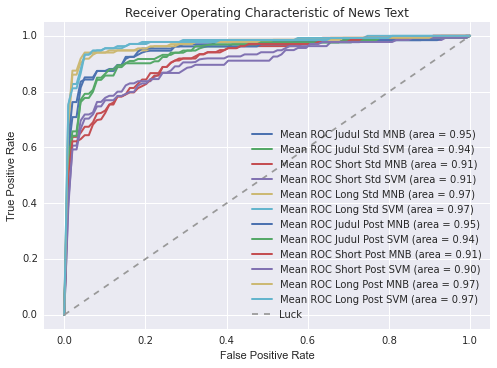

In [255]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

metric = []
for xi in X1:
    X_ = xi['Data']
    for mod in models:
        xP = X_[y_[y_.values == 1].index]
        xN = X_[y_[y_.values == -1].index][:size]
        X  = np.append(xP,xN)
        
        yP = y_[y_.values == 1]
        yN = y_[y_.values == -1][:size]
        y  = np.append(yP,yN)
        
        metrics,mean_fpr,mean_tpr = skorStratCV(mod['pipe'],X,y)
        name = xi['name']+' '+xi['Prep']+' '+mod['name']
        plt.plot(mean_fpr, mean_tpr,label='Mean ROC %s (area = %0.2f)' % (name,metrics[6]), lw=2)
        
        metric.append({'name':name,'metrics':metrics})

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of News Text')
plt.legend(loc="lower right")
plt.show()

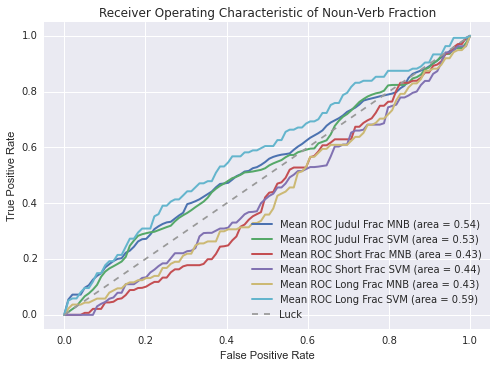

In [256]:
for xi in X2:
    X_ = xi['Data']
    for mod in models_frac:
        xP = X_[y_[y_.values == 1].index]
        xN = X_[y_[y_.values == -1].index][:size]
        X  = np.vstack((xP,xN))
        
        yP = y_[y_.values == 1]
        yN = y_[y_.values == -1][:size]
        y  = np.append(yP,yN)
        
        metrics,mean_fpr,mean_tpr = skorStratCV(mod['pipe'],X,y)
        name = xi['name']+' '+xi['Prep']+' '+mod['name']
        plt.plot(mean_fpr, mean_tpr,label='Mean ROC %s (area = %0.2f)' % (name,metrics[6]), lw=2)
        
        metric.append({'name':name,'metrics':metrics})

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of Noun-Verb Fraction')
plt.legend(loc="lower right")
plt.show()

In [258]:
from ipy_table import *
metrics_table = []
tables = []
columns = (['id', 'nama','training time', 'testing time','p_1',
            'r_1','F1 score','accuracy','ROC'])
tables.append(columns)

i = 0

for me in metric:
    i += 1
    
    metr = []
    metr.append(i)
    metr.append(me['name'])
    for m in me['metrics']:
        metr.append(m)

    tables.append(metr)
    metrics_table.append(metr)
    #print metric
    
make_table(tables)

# styling
apply_theme('basic_both')
set_column_style(7, align='center')

id,nama,training time,testing time,p_1,r_1,F1 score,accuracy,ROC
1,Judul Std MNB,19000,2000,0.8332,0.7758,0.7913,0.9280,0.9487
2,Judul Std SVM,227100,5600,0.8158,0.7516,0.7570,0.9150,0.9375
3,Short Std MNB,34100,3400,0.8061,0.6505,0.7020,0.9058,0.9148
4,Short Std SVM,300900,6400,0.7748,0.6577,0.6981,0.9018,0.9051
5,Long Std MNB,328900,35000,0.9244,0.7769,0.8329,0.9476,0.9663
6,Long Std SVM,648400,70900,0.9299,0.8297,0.8705,0.9568,0.9733
7,Judul Post MNB,14900,3400,0.8378,0.7753,0.7935,0.9293,0.9471
8,Judul Post SVM,185700,3100,0.8073,0.7890,0.7785,0.9202,0.9391
9,Short Post MNB,17600,3200,0.7798,0.6286,0.6850,0.8993,0.9109
10,Short Post SVM,221700,3100,0.7331,0.6357,0.6684,0.8900,0.8960


In [259]:
evals = pd.DataFrame(metrics_table,columns=columns)
evals['Vars'] = [i.split()[0] for i in evals['nama']]
evals['Prep'] = [i.split()[1] for i in evals['nama']]
evals['Algs'] = [i.split()[2] for i in evals['nama']]
evals.drop('nama',axis=1,inplace=True)
evals.drop('id',axis=1,inplace=True)

In [260]:
splitter = ['Judul','Short','Long']
eval_teks = pd.DataFrame([evals[evals.Vars == i].mean() for i in splitter]).transpose()
eval_teks.set_axis(1,splitter)
eval_teks

,Judul,Short,Long
training time,81483.333333,102233.333333,272600.000000
testing time,2650.000000,2683.333333,29850.000000
p_1,0.576455,0.548484,0.645066
r_1,0.556227,0.533059,0.687912
F1 score,0.549925,0.508528,0.614725
accuracy,0.859955,0.815560,0.812807
ROC,0.807347,0.749320,0.816625


In [261]:
splitter = ['Post','Std','Frac']
eval_prep = pd.DataFrame([evals[evals.Prep == i].mean() for i in splitter]).transpose()
eval_prep.set_axis(1,splitter)
eval_prep

,Post,Std,Frac
training time,176250.000000,259733.333333,20333.333333
testing time,13816.666667,20550.000000,816.666667
p_1,0.835605,0.847365,0.087034
r_1,0.741575,0.740385,0.295238
F1 score,0.773017,0.775303,0.124859
accuracy,0.924308,0.925837,0.638177
ROC,0.938883,0.940955,0.493455


In [262]:
splitter = ['MNB','SVM']
eval_teks = pd.DataFrame([evals[evals.Algs == i].mean() for i in splitter]).transpose()
eval_teks.set_axis(1,splitter)
eval_teks

,MNB,SVM
training time,70600.000000,233611.111111
testing time,7355.555556,16100.000000
p_1,0.568227,0.611775
r_1,0.488706,0.696093
F1 score,0.516660,0.598793
accuracy,0.892033,0.766849
ROC,0.784889,0.797306


In [31]:
mnb

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [50]:
#knn
# knn_params = {'n_neighbors': range(1,21), 'weights': ['uniform', 'distance'], 'algorithm': ['ball_tree', 'kd_tree'],
#               'leaf_size': [15, 30, 50, 100], 'p': [1,2]}

In [33]:
svc
# lsvm_params = {'loss':['hinge', 'squared_hinge'],'class_weight':['balanced']}

SVC(C=1.0, cache_size=600, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [51]:
#tre
# tree_param = {"criterion": ["gini", "entropy"],"class_weight" : ['balanced']}